In [1]:
from IPython.display import Image

# Atmospheric Retrievals

*This notebook demonstrates the use of ExoCTK's `platon_wrapper` module.  As suggested by its name, this module is a wrapper around the `platon.retreiver.run_multinest` and `platon.retriever.run_emcee` methods, which uses multinested sampling and MCMC algorithms to retrieve atmospheric parameters, respectively.  For further information about `platon`, see the [project documentation](https://platon.readthedocs.io/en/latest/), the [API docs for the `retriever` module](https://platon.readthedocs.io/en/latest/source/platon.html#module-platon.retriever), or the [GitHub repository](https://github.com/ideasrule/platon).*

*Note that some of the examples provided below are minimal, bare-bones examples that are meant to show how users may use the software while not taking much computation time to complete.  The parameters used and the corresponding results are not indiative of a true scientific use case.  For more comprehensive and robust examples, see the `examples.py` module in the `exoctk.atmospheric_retrievals` subpackage.*

*The [first section](#simple-example) of this notebook provides a simple example of how to run the software on a local machine.  The [later sections](#aws) describe how to perform retrievals using Amazon Web Services (AWS) Elastic Computing (EC2) instances.*

*This notebook assumes that the user has installed the `exoctk` package and its required libraries.  For more information about the installation of `exoctk`, see the [installation instructions](https://github.com/ExoCTK/exoctk#installation).*

<a id='simple-example'></a>
## A Simple Example

_Provided below is a simple example of how to use the `PlatonWrapper` object to perform atmospheric retrievals.  First, a few necessary imports:_

In [ ]:
import numpy as np
from platon.constants import R_sun, R_jup, M_jup
from exoctk.atmospheric_retrievals.platon_wrapper import PlatonWrapper

*The `PlatonWrapper` object requires the user to supply a dictionary containing initial guesses of parameters that they wish to fit.  Note that `Rs`, `Mp`, `Rp`, and `T` must be supplied, while the others are optional.*

*Also note that `Rs` are in units of solar radii, `Mp` are in units of Jupiter masses, and `Rp` is is units of Jupiter radii.*

In [ ]:
params = {
    'Rs': 1.19,  # Required
    'Mp': 0.73,  # Required
    'Rp': 1.4,  # Required
    'T': 1200.0,  # Required
    'logZ': 0,  # Optional
    'CO_ratio': 0.53,  # Optional
    'log_cloudtop_P': 4,  # Optional
    'log_scatt_factor': 0,  # Optional
    'scatt_slope': 4,  # Optional
    'error_multiple': 1,  # Optional
    'T_star': 6091}  # Optional

*In order to perform the retrieval, users must instantiate a `PlatonWrapper` object and set the parameters*

In [ ]:
pw = PlatonWrapper()
pw.set_parameters(params)

*Users may define fitting priors via the `fit_info` attribute.*

In [ ]:
pw.fit_info.add_gaussian_fit_param('Mp', 0.04*M_jup)
pw.fit_info.add_uniform_fit_param('Rp', 0.9*(1.4 * R_jup), 1.1*(1.4 * R_jup))
pw.fit_info.add_uniform_fit_param('T', 300, 3000)
pw.fit_info.add_uniform_fit_param("logZ", -1, 3)
pw.fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)

*Prior to performing the retrieval, users must define `bins`, `depths`, and `errors` attributes.  The `bins` atribute must be a list of lists, with each element being the lower and upper bounds of the wavelenth bin.  The `depths` and `errors` attributes are both 1-dimensional `numpy` arrays.*

In [ ]:
wavelengths = 1e-6*np.array([1.119, 1.1387])
pw.bins = [[w-0.0095e-6, w+0.0095e-6] for w in wavelengths]
pw.depths = 1e-6 * np.array([14512.7, 14546.5])
pw.errors = 1e-6 * np.array([50.6, 35.5])

*With everything defined, users can now perform the retrieval.  Users may choose to use the the MCMC method (`emcee`) or the Multinested Sampling method (`multinest`)*

### MCMC Method

In [ ]:
pw.retrieve('emcee')
pw.save_results()
pw.make_plot()

### Mulinested Sampling Method

In [ ]:
pw.retrieve('multinest')
pw.save_results()
pw.make_plot()

*Note that results are saved in a text file named `<method>_results.dat`, a corner plot is saved to `<method>_corner.png`, and a log file describing the execution of the software is saved to `YYYY-MM-DD-HH-MM.log`, which is a timestamp reflecting the creation time of the log file.*

<a id='aws'></a>
## Using Amazon Web Services to Perform Atmospheric Retrievals

The following sections guide users on how to perform atmospheric retrievals using Amazon Web Services (AWS) Elastic Computing (EC2) instances.

**Table of Contents:**
1. [What is Amazon Web Servies?](#what-is-amazon-web-services)
2. [What is an EC2 instance?](#what-is-an-ec2-instance)
3. [Why use AWS?](#why-use-aws)
4. [AWS-specific software in the `atmospheric_retrievals` subpackage](#aws-specific-software-in-the-atmospheric-retrievals-subpackage)
5. [Setting up an AWS account](#setting-up-an-aws-account)
6. [Create a SSH key pair](#create-a-ssh-key-pair)
7. [Launch an EC2 instance](#launch-an-ec2-instance)
8. [Build the `exoctk` software environment on the EC2 instance](#build-the-exoctk-software-environment-on-the-ec2-instance)
8. [Fill out the `aws_config.json` file](#fill-out-the-aws-config.json-file)
9. [Run some code!](#run-some-code)
10. [Output products](#output-products)
11. [Using a GPU-enabled EC2 instance](#using-a-gpu-enabled-ec2-instance)

<a id='what-is-amazon-web-services'></a>
### What is Amazon Web Services?

Amazon Web Services provides on-demand cloud-based computing platforms, with a variety of services such as Elastic Compute Cloud (EC2), Cloud Storage (S3), Relational Database Service (RDS), and more.  Learn more at https://aws.amazon.com/what-is-aws/

<a id='what-is-an-ec2-instance'></a>
### What is an EC2 instance?

The Elastic Compute Cloud (EC2) service enables users to spin up virtual servers, with a variety of operating systems, storage space, memory, and number of CPUs. Learn more at https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/concepts.html

<a id='why-use-aws'></a>
### Why use AWS?

Atmospheric retrievals are often computationally expensive, both in the amount of time it takes to complete a retrieval, but also in the cost of purchasing and/or maintaining a suitable machine.  Particularly, if users do not have access to a dedicated science machine or cluster, and instead must rely on personal laptops or desktops, atmospheric retrievals can become quite burdensome in day-to-day research work.

AWS provides a means to outsource this computational effort to machines that live in the cloud, and for low costs.  With AWS, users can create a virtual machine (VM), perform a atmospheric retrievals, and have the machine automatically shutdown upon completion.  Depending on the type of VM, typical costs can range from anywhere between ~\\$0.02/hour (i.e. a small, 1 CPU Linux machine) to ~\\$3.00/hour (i.e. a heftier, multiple CPU, GPU-enabled Linux machine).

For example, a small trial run of an atmospheric retrieval for hd209458b using PLATON takes roughly 35 minutes at a total cost of \\$0.01 using a small CPU EC2 instance, and took roughly 24 minutes at a total cost of \\$1.22 using a GPU-enabled EC2 instance.

<a id='aws-specific-software-in-the-atmospheric-retrievals-subpackage'></a>
### AWS-specific software in the `atmospheric_retrievals` subpackage

The `atmospheric_retrievals` subpackage provides software that enables users to use AWS EC2 instances to perform atmospheric retrievals.  The relevant software modules/tools are:

- `aws_config.json` - a configuration file that contains a path the a public ssh key and a pointer to a particular EC2 instance
- `aws_tools.py` - Various functions to support AWS EC2 interactivity, such as starting/stoping an EC2 instance, transferring files to/from EC2 instances, and logging standard output from EC2 instances
- `build-exoctk-env-cpu.sh` - A bash script for creating an `exoctk` software environment on an EC2 instance
- `build-exoctk-env-gpu.sh` - A bash script for creating an `exoctk` software environment on a GPU-enabled EC2 instance
- `exoctk-env-init.sh` - A bash script that initializes an existing `exoctk` software environment on an EC2 instance

<a id='setting-up-an-aws-account'></a>
### Setting up an AWS account

Users must first set up an AWS account and configure a ssh key pair in order to connect to the services.  Users may visit https://aws.amazon.com to create an account.  Unfortunately, a credit card is required for sign up.  There is no immediate fee for signing up; users will only incur costs when a service is used.

<a id='create-a-ssh-key-pair'></a>
### Create a SSH key pair

In order to connect to an EC2 instance, users must first configure an SSH key pair:

1. In a terminal, type `ssh-keygen -t rsa -f <rsa_key_name>`, where `<rsa_key_name>` is the name of the resulting ssh key files.  When prompted to enter a passphrase, leave it empty by hitting `enter`, and then `enter` again.  Running this command should result in the creation of two files: (1) `<rsa_key_name>`, which is the private SSH key, and `<rsa_key_name>`.pub, which is the public SSH key.
2. In the AWS EC2 console (https://console.aws.amazon.com/ec2), navigate to `Key Pairs` under `Network & Security` on the left hand side of the page.
3. Select `Import key pair`
4. In the `Name` field, enter a name you wish to use.
5. In the large field on the bottom, paste the contents of the `<rsa_key_name>` file.  
6. Select `Import key pair` to complete the process.

<a id='launch-an-ec2-instance'></a>
### Launch an EC2 instance

To create and launch an EC2 instance:

1. Select "Instances" from the left-hand side of the AWS EC2 console
2. Select the "Launch Instance" button
3. Select an Amazon Machine Image (AMI) of your choosing.  Note that there is a box on the left that allows users to only show free tier only eligible AMIs.  For the purposes of the examples in this notebook, it is suggested to use `ami-0c322300a1dd5dc79` (Red Hat Enterprise Linux 8 (HVM), SSD Volume Type, 64-bit (x86)).
4. Select the Instance Type with the configuration of your choosing.  For the purposes of the examples in this notebook, it is suggested to use `t2.micro`, which is free tier eligible.  When satisfied, choose "Review and Launch"
5. On the "Review Instance Launch" page, users may review and/or change any settings prior to launching the EC2 instance.  For the purposes of the examples in this notebook, it is suggested to "Edit storage" and increase the "Size" to 20 GiB to allow enough storage space to build the `exoctk` software environment.
6. When satisfied, click "Launch".  The user will be prompted to select or create a key pair.  Select the existing key pair that was created in the [Create a SSH key pair](#create-a-ssh-key-pair) section.  Check the acknowledgement box, and select "Launch Instances"
7. If the EC2 instance was launched successfully, there will be a success message with a link to the newly-created EC2 instance.

_Note: For users interested in using GPU-enabled EC2 instances, see the [Using a GPU-enabled EC2 instance](#using-a-gpu-enabled-ec2-instance) section at the end of this notebook.  This warrants its own section because it requires a rather complex installation process._

<a id='build-the-exoctk-software-environment-on-the-ec2-instance'></a>
### Build the `exoctk` software environment on the EC2 instance

Once the newly-created EC2 instance has been in its "Running" state for a minute or two, users can log into the machine through the command line and install the necessary software dependencies needed for running the `atmospheric_retrievals` code.

To log into the EC2 instance from the command line, type:

```bash
ssh -i <path_to_private_key> ec2-user@<ec2_public_dns>
```

where `<path_to_private_key>` is the path to the private SSH key file (i.e. the `<rsa_key_name>` that was created in the [Create a SSH key file](#create-a-ssh-key-pair) section), and `<ec2_public_dns>` is the Public DNS of the EC2 instance, which is provided in the "Description" of the EC2 instance under the "Instances" panel in the AWS EC2 console.  This public DNS should look something like `ec2-NN-NN-NNN-NN.compute-N.amazonaws.com`.

Once logged in, users can build the `exoctk` software environment by either copy/pasting the commands from the `atmospheric_retrievals/build-exoctk-env-cpu.sh` file straight into the terminal, or by copying the `build-exoctk-env-cpu.sh` file directly to the EC2 instance and running it, as such:

```bash
scp -i <path_to_private_key> build-exoctk-env-cpu.sh ec2-user@<ec2_public_dns>:/home/ec2-user/build-exoctk-env-cpu.sh
ssh -i <path_to_private_key> ec2-user@<ec2_public_dns>
./build-exoctk-env-cpu.sh
```

Once completed, users may log out of the EC2 instance, as there will no longer be any command-line interaction needed.

<a id='fill-out-the-aws-config.json-file'></a>
### Fill out the `aws_config.json` file

Within the `atmospheric_retrievals` subpackage, there exists an `aws_config.json` file.  Fill in the values for the two fields: `ec2_id`, and `ssh_file`.  The `ec2_id` should contain the name of  EC2 template ID (which can be found under "Instance ID" in the description of the EC2 instance in the AWS EC2 console), and `ssh_file` should point to the location of the private SSH file described in the [Create a SSH key pair](#create-a-ssh-key-pair) section:

```json
{
    "ec2_id" : "<ec2_instance_ID>",
    "ssh_file" : "<path_to_private_key>"
}
```

<a id='run-some-code'></a>
### Run some code!

Now that we have configured everything to run on AWS, the next step is to simply perform a retrieval!  To invoke the use of the AWS EC2 instance, simply use the `use_aws()` method before performing the retrieval.  A short example is provided below.

```python
import numpy as np
from platon.constants import R_sun, R_jup, M_jup
from exoctk.atmospheric_retrievals.aws_tools import get_config
from exoctk.atmospheric_retrievals.platon_wrapper import PlatonWrapper

params = {
    'Rs': 1.19,  # Required
    'Mp': 0.73,  # Required
    'Rp': 1.4,  # Required
    'T': 1200.0,  # Required
    'logZ': 0,  # Optional
    'CO_ratio': 0.53,  # Optional
    'log_cloudtop_P': 4,  # Optional
    'log_scatt_factor': 0,  # Optional
    'scatt_slope': 4,  # Optional
    'error_multiple': 1,  # Optional
    'T_star': 6091}  # Optional

pw = PlatonWrapper()
pw.set_parameters(params)

pw.fit_info.add_gaussian_fit_param('Mp', 0.04*M_jup)
pw.fit_info.add_uniform_fit_param('Rp', 0.9*(1.4 * R_jup), 1.1*(1.4 * R_jup))
pw.fit_info.add_uniform_fit_param('T', 300, 3000)
pw.fit_info.add_uniform_fit_param("logZ", -1, 3)
pw.fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)

wavelengths = 1e-6*np.array([1.119, 1.1387])
pw.bins = [[w-0.0095e-6, w+0.0095e-6] for w in wavelengths]
pw.depths = 1e-6 * np.array([14512.7, 14546.5])
pw.errors = 1e-6 * np.array([50.6, 35.5])

ssh_file = get_config()['ssh_file']
ec2_id = get_config()['ec2_id']
pw.use_aws(ssh_file, ec2_id)

pw.retrieve('multinest')
pw.save_results()
pw.make_plot()
```

<a id='output-products'></a>
### Output products

Executing the above code will result in a few output files:

- `YYYY-MM-DD-HH-MM.log` - A log file that captures information about the execution of the code, including software environment information, EC2 start/stop information, retrieval information and results, and total computation time.
- `multinest_results.dat`/`emcee_results.obj` - A data file containing the best fit results of the retrieval.  Note that `emcee` results are saved as a Python object and saved to an object file.
- `<method>_corner.png` - A corner plot describing the quality of the best fit results of the retrieval, where `<method>` is the method used (i.e. `multinest` or `emcee`)

Here is an example of what these output products may look like:

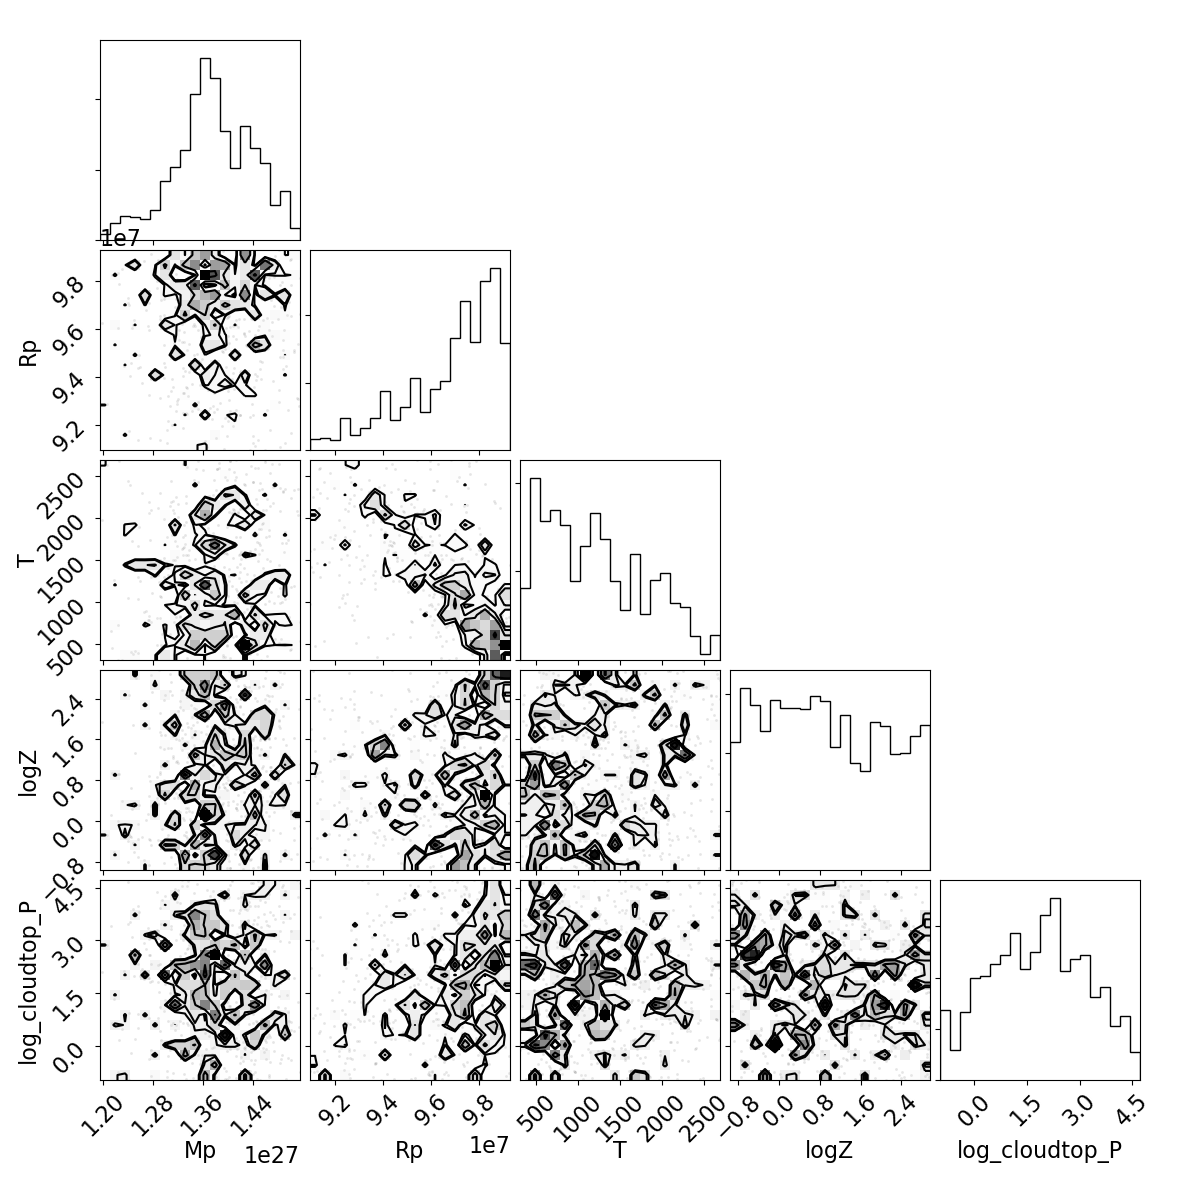

In [2]:
Image(filename='corner_plot.png')

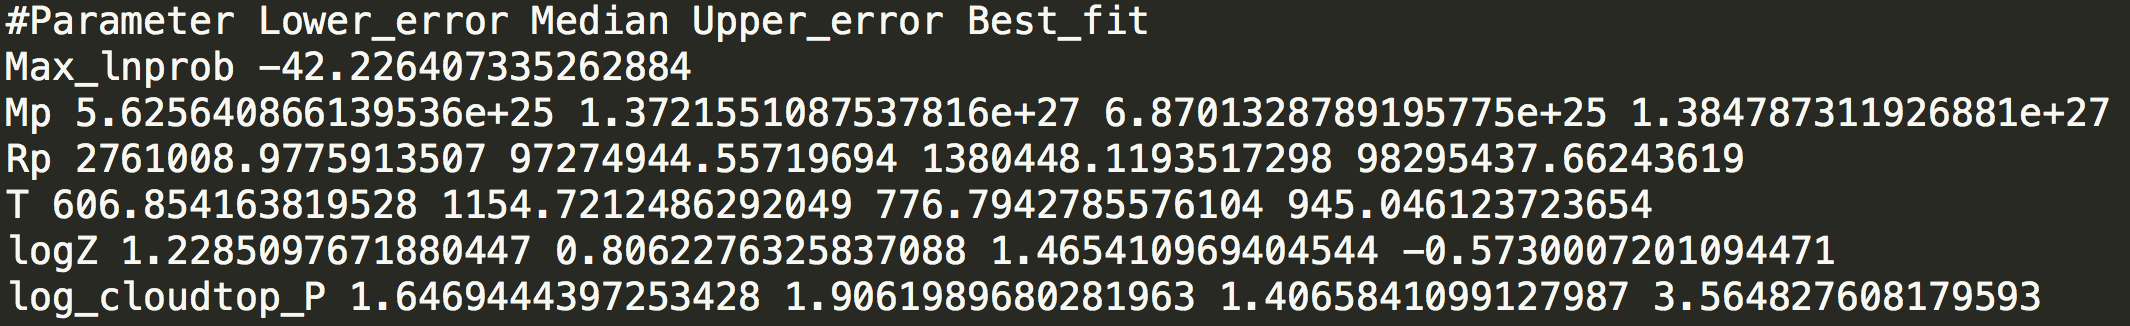

In [3]:
Image(filename='results.png')

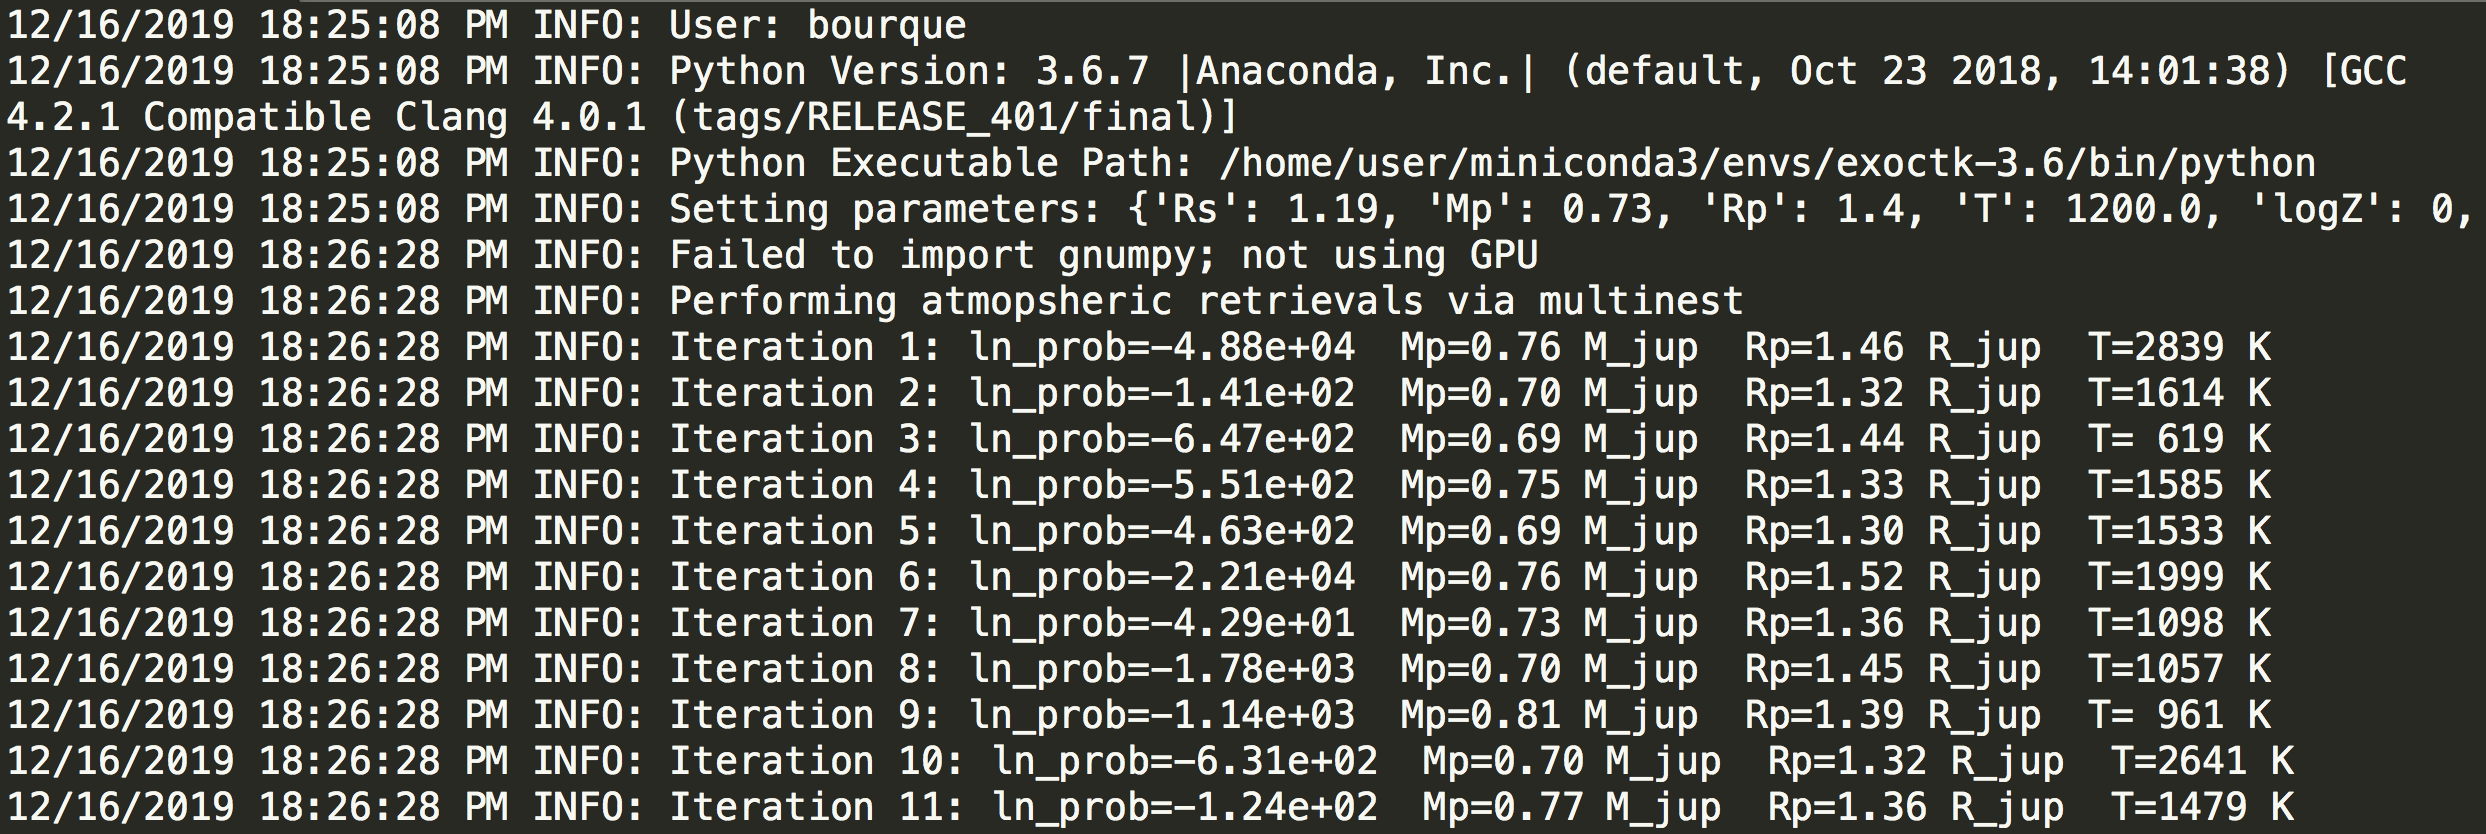

In [4]:
Image(filename='log_file.png')

<a id='using-a-gpu-enabled-ec2-instance'></a>
### Using a GPU-enabled EC2 instance

The `atmospheric_retrieval` subpackage supports the use of GPU-enabled EC2 instances.  Users may create a GPU-enabled AMI/instance type configuration, such as AMI `ami-0c322300a1dd5dc79` with instance type `p3.2xlarge`, which contains multiple GPUs.  However, the process for building a GPU-enabled `exoctk` software environment is more complex than that is described in the [Build the `exoctk` software environment on the ec2 instance](#build-the-exoctk-software-environment-on-the-ec2-instance) section, as it involves multiple machine reboots and thus cannot be easily installed by running a single bash script.

Below are instructions for installing/configuring the software environment needed for the GPU-enabled EC2 instance.  These commands are also provided in the `atmospheric_retrievals/build-exoctk-env-gpu.sh` file.

1. First create a GPU-enabled EC2 instance, as described above and in the [Launch an EC2 instance](#launch-an-ec2-instance) section.
2.  Once the EC2 instance is created, navigate back to the AWS EC2 console and select "Instances" on the left side of the page to see a list of EC2 instances.  Users should see the EC2 instance that was just created.
3.  Allow the EC2 instance to enter the "Running" phase for a minute or two.  Then, connect to the machine via the command line, as described in the [Build the `exoctk` software environment on the EC2 instance](#build-the-exoctk-software-environment-on-the-ec2-instance) section.
4. Once logged into the machine, users can now begin to run the necessary installation commands, provided below:

```bash
// Install NVIDIA GPU Driver
sudo yum -y update
sudo yum -y install wget nano elfutils-libelf-devel
sudo yum -y groupinstall "Development Tools"
sudo sed -i 's/crashkernel=auto"/crashkernel=auto nouveau.modeset=0"/g' /etc/default/grub
sudo grub2-mkconfig -o /boot/grub2/grub.cfg
sudo touch /etc/modprobe.d/blacklist.conf
sudo chmod 777 /etc/modprobe.d/blacklist.conf
sudo echo 'blacklist nouveau' > /etc/modprobe.d/blacklist.conf
sudo mv /boot/initramfs-$(uname -r).img /boot/initramfs-$(uname -r)-nouveau.img
sudo dracut /boot/initramfs-$(uname -r).img $(uname -r)
sudo reboot
```

5. Allow EC2 to reboot, then when the EC2 is running again, log back into the instance.

```bash
sudo systemctl isolate multi-user.target
wget http://us.download.nvidia.com/XFree86/Linux-x86_64/430.40/NVIDIA-Linux-x86_64-430.40.run
sudo sh NVIDIA-Linux-x86_64-430.40.run
// Choose "No" when prompted to install 32-bit
sudo reboot
```

6. Again, allow EC2 to reboot, then when the EC2 is running again, log back into the instance.

```bash
// Install CUDA Toolkit
wget http://developer.download.nvidia.com/compute/cuda/10.1/Prod/local_installers/cuda_10.1.243_418.87.00_linux.run
sudo sh cuda_10.1.243_418.87.00_linux.run
// Unselect 
export PATH=$PATH:/usr/local/cuda-10.1/bin
export LD_LIBRARY_PATH=/usr/local/cuda-10.1/lib64

// Install Anaconda
curl -O https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod 700 ./Miniconda3-latest-Linux-x86_64.sh
bash ./Miniconda3-latest-Linux-x86_64.sh -b -p $HOME/miniconda3

// Set important environment variables
export PATH=/home/ec2-user/miniconda3/bin:$PATH
export EXOCTK_DATA=''

// Create base CONDA 
conda create --yes -n exoctk-3.6 python=3.6 git numpy flask pytest
conda init bash
source ~/.bashrc
conda activate exoctk-3.6

// Install ExoCTK package and conda environment
git clone https://github.com/ExoCTK/exoctk.git
cd exoctk/
conda env update -f env/environment-3.6.yml
conda init bash
source ~/.bashrc
conda activate exoctk-3.6
python setup.py develop
cd ../

// Install jwst_gtvt
rm -fr /home/ec2-user/miniconda3/envs/exoctk-3.6/lib/python3.6/site-packages/jwst_gtvt
git clone https://github.com/spacetelescope/jwst_gtvt.git
cd jwst_gtvt
git checkout cd6bc76f66f478eafbcc71834d3e735c73e03ed5
python setup.py develop
cd ../

// Install additional libraries
pip install bibtexparser==1.1.0
pip install corner==2.0.1
pip install lmfit==0.9.13
pip install platon==3.1

// Install cudamat
git clone https://github.com/cudamat/cudamat.git
sudo sed -i "s/-O',/-O3',/g" /home/ec2-user/cudamat/setup.py
cd cudamat
python setup.py develop
cd ../

// Install gnumpy
git clone https://github.com/ExoCTK/gnumpy3.git
cd gnumpy3
python setup.py develop
cd ../

// Build skeleton EXOCTK_DATA directory
mkdir exoctk_data/
mkdir exoctk_data/exoctk_contam/
mkdir exoctk_data/exoctk_log/
mkdir exoctk_data/fortney/
mkdir exoctk_data/generic/
mkdir exoctk_data/groups_integrations/
mkdir exoctk_data/modelgrid/

// Print the complete environment
conda env export
```

Now that the EC2 instance is configured, select the EC2 instance in the AWS console and select "Actions > Stop" to stop the instance.  Paste the EC2 instance ID into the `ec2_id` key in the `aws_config.json` file to point to the instance for processing.

At this point, users may now run code like the example in the [Run some code!](#run-some-code) section, but now retrievals will be performed on the GPU-enabled EC2 instance.

**Author:** _Matthew Bourque, Software Engineer, Space Telescope Science Institute_